# Class Imbalance

My business goal is identifying whether the company will bankrupt or not in next 1-5 years. 

I will use Ensemble Method 'XGBoost', eXtreme Gradient Boosting, for classification.

I will focus on the performance of 'recall' metric in order to minimize false negatives. Besides, I will also keep an eye on 'f1', and 'AUC' metrics.

**In this botebook, I will work on the class imbalance issue on the dataset.**

## Load Libraries

In [16]:
# Import base libraries
import pandas as pd
import numpy as np
from scipy.io import arff

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.utils import class_weight

from functions import *

from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

## Load Data

There are five data files: 
    * data1, 1year.arff 
    * data2, 2year.arff 
    * data3, 3year.arff
    * data4, 4year.arff
    * data5, 5year.arff

Initially, I will use 'data3' to find the best approcah to handle the class imbalance. 

No cleaning applied to data. XGBoost Classifier can handle the missing values.

In [23]:
# Load data
data3 = arff.loadarff('data/3year.arff')
df3 = pd.DataFrame(data3[0])

# Change label/class type to binary
df3['class'] = df3['class'].astype('int64')

df3.shape

(10503, 65)

## Pre-process

In [24]:
# Assign target and predictor
y = df3['class']
X = df3.drop('class', axis=1)

# Sepearate data into train and test splist
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Scale/Normalize the predictor variables
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

print('X_train shape = ', X_train.shape)
print('y_train shape = ', y_train.shape)
print('X_test shape = ', X_test.shape)
print('y_test shape = ', y_test.shape)

X_train shape =  (8402, 64)
y_train shape =  (8402,)
X_test shape =  (2101, 64)
y_test shape =  (2101,)


## Baseline Model


In [19]:
# Baseline Model

xgbParams = {
    'eval_metric': 'logloss', 
    'random_state': 42,
}

baseline_model = xgb_model_report(3, X_train, y_train, X_test, y_test, xgbParams, 'baseline_model', 0, 1, 1)

Data 3 Classification Report:

Training Data:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      8014
           1       1.00      1.00      1.00       388

    accuracy                           1.00      8402
   macro avg       1.00      1.00      1.00      8402
weighted avg       1.00      1.00      1.00      8402

Testing Data:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98      1994
           1       0.93      0.47      0.62       107

    accuracy                           0.97      2101
   macro avg       0.95      0.73      0.80      2101
weighted avg       0.97      0.97      0.97      2101



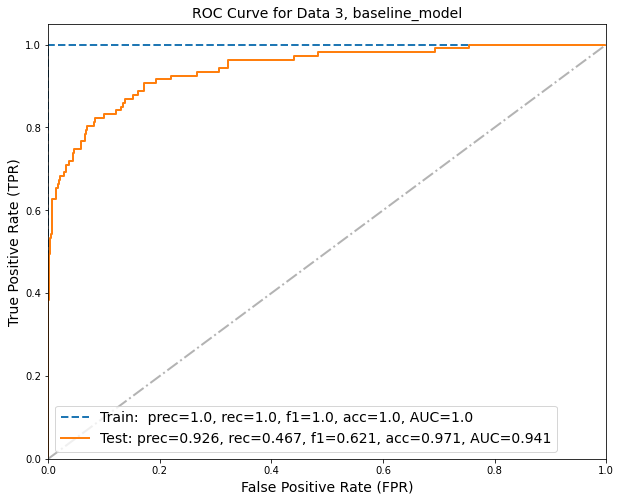

In [6]:
#Plot ROC curve

plot_ROC(3, X_train, y_train, X_test, y_test, baseline_model, 'baseline_model', 1)

In [7]:
model_1.get_params

<bound method XGBModel.get_params of XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, random_state=42, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)>

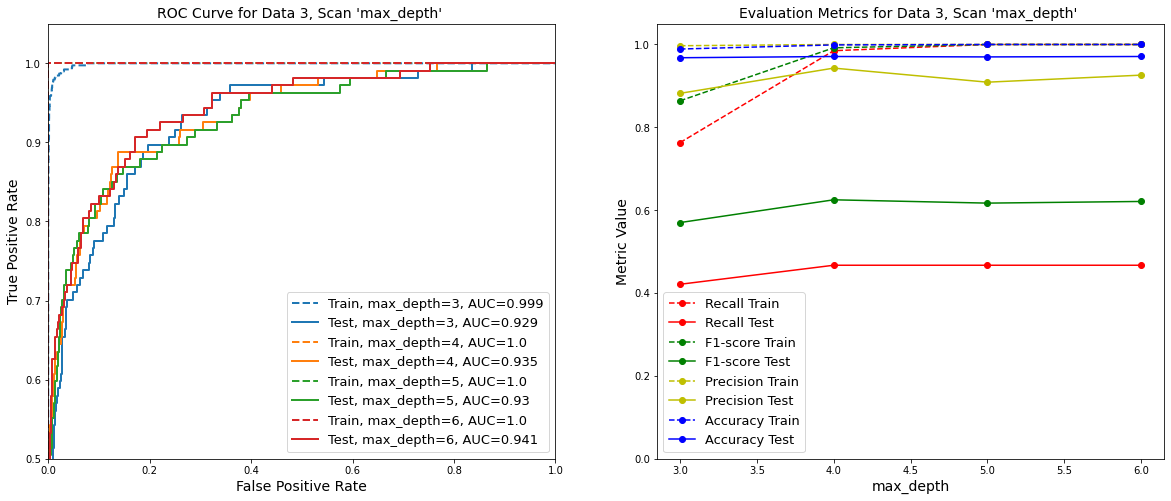

In [33]:
#Scan max_depth

xgbParams = {
    'eval_metric': 'logloss', 
    'random_state': 42,
}

scanParam = 'max_depth'

scanList = [3, 4, 5, 6]

result_sw_depth = scan_xgb_ROC_metrics(3, X_train, y_train, X_test, y_test, xgbParams, scanParam, scanList, 0, 1, 0)

**Comments**

* According to testing data results, the model performance in identfying the non-bankruptcy companies (class 0) is very good. 
* However, the identification of the bankruptcy companies (class 1) is not that good (low recall and f1)
* The class imbalance is probaly the reason for the class 0/1 performance difference.
* There is large overfitting.


## Class Imbalance

There are two approaches to deal with the class imbalance:
* 'sample_weight' parameter when training the data
* 'scale_pos_weight' parameter when initiating the classifier

### sample_weight

In [24]:
# Whole data 3

print('Whole Data3')
d3_class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=[0,1], y=df3['class'])
print(d3_class_weights)

d3_class_weights_ratio = d3_class_weights[1]/d3_class_weights[0]
print('weights_ratio', d3_class_weights_ratio)
print('Squared Root of weights_ratio', np.sqrt(d3_class_weights_ratio))

Whole Data3
[ 0.52473022 10.60909091]
weights_ratio 20.21818181818182
Squared Root of weights_ratio 4.496463256625347


In [28]:
#Training sample

print('Training sample, Data3')
d3_class_weights_train = class_weight.compute_class_weight(class_weight='balanced', classes=[0,1], y=y_train)

d3_class_weights_train_ratio = d3_class_weights_train[1]/d3_class_weights_train[0]
print('weights_ratio', d3_class_weights_train_ratio)
print('Squared Root of weights_ratio', np.sqrt(d3_class_weights_train_ratio))

d3_class_weights_train_array = class_weight.compute_sample_weight(class_weight='balanced', y=y_train)
print('Class weights per entry:', d3_class_weights_train_array)

# Training weights are used for data training.

Training sample, Data3
weights_ratio 20.65463917525773
Squared Root of weights_ratio 4.544737525452678
Class weights per entry: [0.52420764 0.52420764 0.52420764 ... 0.52420764 0.52420764 0.52420764]


In [31]:
# sample_weight applied

xgbParams = {
    'eval_metric': 'logloss', 
    'random_state': 42,
}

xgb_model_sw = xgb_model_report(3, X_train, y_train, X_test, y_test, xgbParams, 'XGB Model', 1, 0, 1)

Sample weights are used!
--------

Data 3 Classification Report:

Training Data:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      8014
           1       1.00      1.00      1.00       388

    accuracy                           1.00      8402
   macro avg       1.00      1.00      1.00      8402
weighted avg       1.00      1.00      1.00      8402

Testing Data:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      1994
           1       0.87      0.54      0.67       107

    accuracy                           0.97      2101
   macro avg       0.92      0.77      0.83      2101
weighted avg       0.97      0.97      0.97      2101



Sample weights are used!
--------



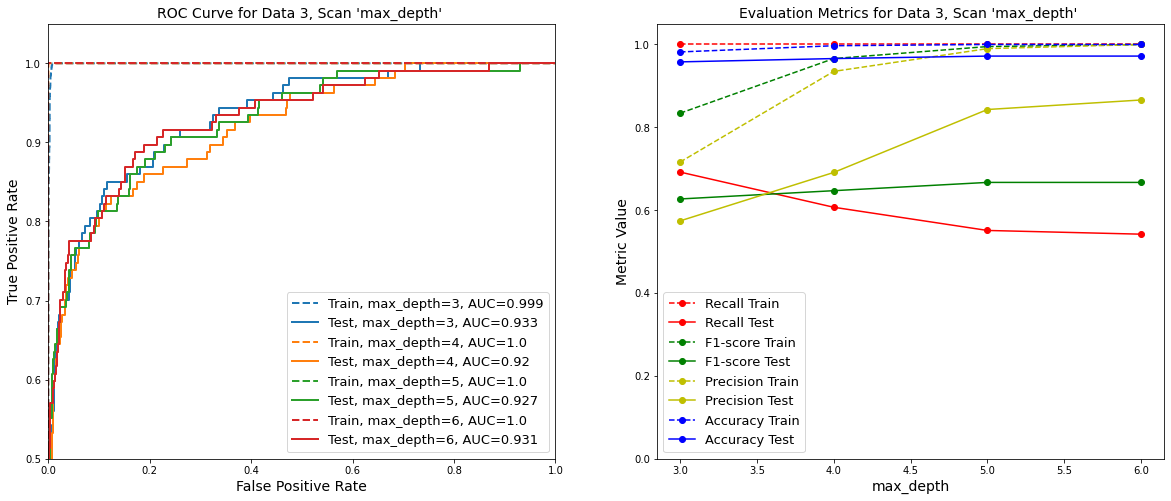

In [35]:
#Scan max_depth
#sample_weight applied

xgbParams = {
    'eval_metric': 'logloss', 
    'random_state': 42,
}

scanParam = 'max_depth'

scanList = [3, 4, 5, 6]

result_sw_depth = scan_xgb_ROC_metrics(3, X_train, y_train, X_test, y_test, xgbParams, scanParam, scanList, 1, 1, 0)

**Comments**

* Model performance improved, Recall increased.
* Overfitting continues.
* sample_weight is more effective at lower max_depth (3 or 4)

### scale_pos_weight

My goal is find the optimum 'scale_pos_weight' value which creates good recall and f1 value.

The model performance is largely effected by the max_depth. So I will scan the scale_pos_weight at several max_depth.

In [29]:
#Check Class Imbalance
df3['class'].value_counts()

0    10008
1      495
Name: class, dtype: int64

In [30]:
#Check Class Imbalance, Normalized
df3['class'].value_counts(normalize=True)

0    0.952871
1    0.047129
Name: class, dtype: float64

In [15]:
# Explore class counts
val_counts = df3['class'].value_counts()
ratio_imbalance = val_counts[0]/val_counts[1]
sqrt_ratio_imbalance = np.sqrt(val_counts[0]/val_counts[1])

print('imbalance ratio:', ratio_imbalance)
print('sqrt of imbalance ratio:', sqrt_ratio_imbalance)

# The values are very similar for train/test/whole datasets.

imbalance ratio: 20.21818181818182
sqrt of imbalance ratio: 4.496463256625347


In [22]:
# Explore class counts, Training sample
val_counts = pd.DataFrame(y_train, columns=['class'])['class'].value_counts()
ratio_imbalance = val_counts[0]/val_counts[1]
sqrt_ratio_imbalance = np.sqrt(val_counts[0]/val_counts[1])

print('imbalance ratio:', ratio_imbalance)
print('sqrt of imbalance ratio:', sqrt_ratio_imbalance)

imbalance ratio: 20.65463917525773
sqrt of imbalance ratio: 4.544737525452678


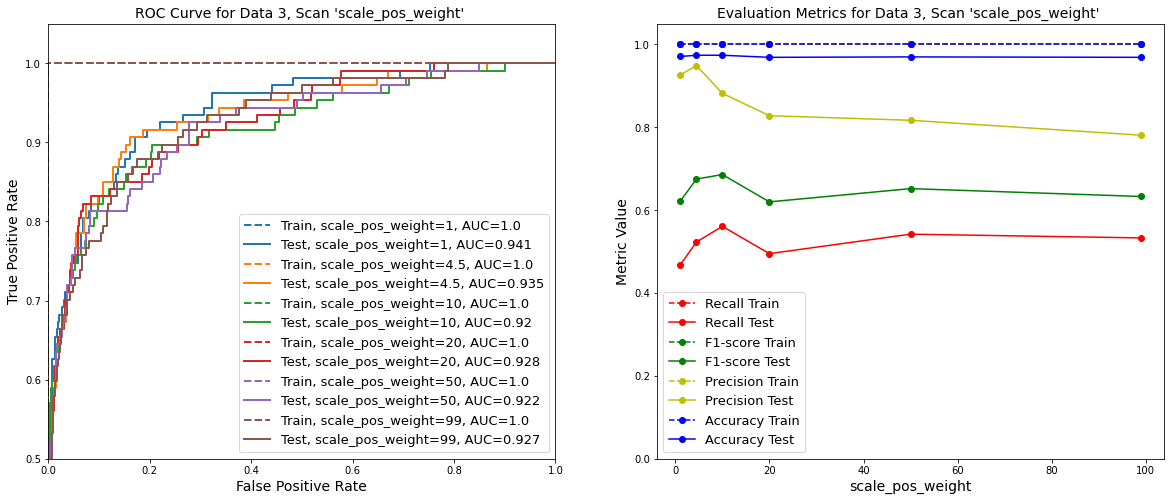

In [37]:
#Scan scale_pos_weight, 
# max_depth=6 (default)

xgbParams = {
    'eval_metric': 'logloss', 
    'random_state': 42,
}

scanParam = 'scale_pos_weight'

scanList = [1, 4.5, 10, 20, 50, 99]
#scanList = [1, 4.5]

result_spw = scan_xgb_ROC_metrics(3, X_train, y_train, X_test, y_test, xgbParams, scanParam, scanList, 0, 1, 0)

In [51]:
# max_depth=6, scale_pos_weight=10

xgbParams = {
    'eval_metric': 'logloss', 
    'random_state': 42,
    'max_depth': 6,
    'scale_pos_weight': 10,
}

model_spw10_depth6 = xgb_model_report(3, X_train, y_train, X_test, y_test, xgbParams, 'XGB Model', 0, 0, 1)

Data 3 Classification Report:

Training Data:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      8014
           1       1.00      1.00      1.00       388

    accuracy                           1.00      8402
   macro avg       1.00      1.00      1.00      8402
weighted avg       1.00      1.00      1.00      8402

Testing Data:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      1994
           1       0.88      0.56      0.69       107

    accuracy                           0.97      2101
   macro avg       0.93      0.78      0.84      2101
weighted avg       0.97      0.97      0.97      2101



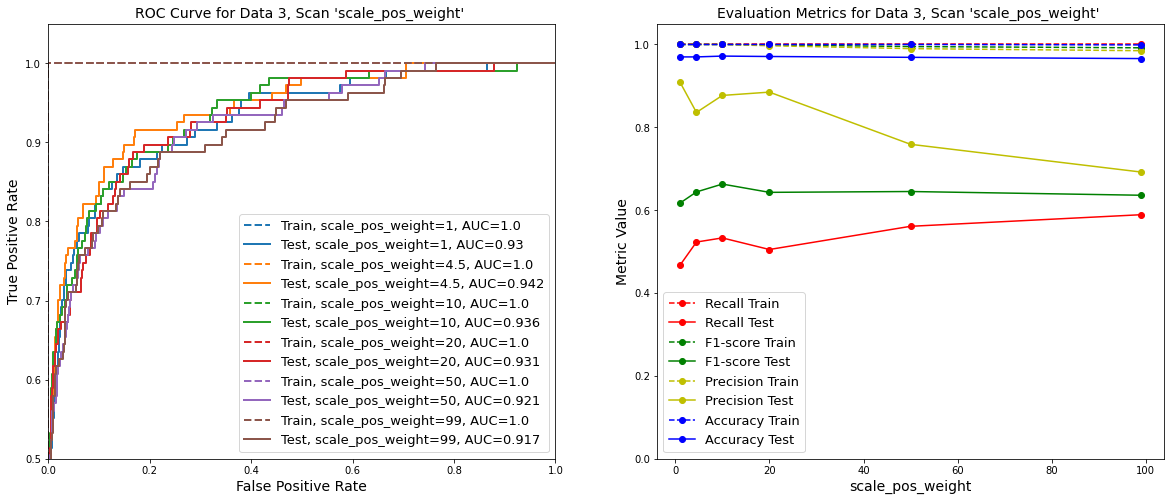

In [40]:
#Scan scale_pos_weight, 
# max_depth=5

xgbParams = {
    'eval_metric': 'logloss', 
    'random_state': 42,
    'max_depth': 5
}

scanParam = 'scale_pos_weight'

scanList = [1, 4.5, 10, 20, 50, 99]
#scanList = [1, 4.5]

result_spw_depth5 = scan_xgb_ROC_metrics(3, X_train, y_train, X_test, y_test, xgbParams, scanParam, scanList, 0, 1, 0)

In [52]:
# max_depth=5, scale_pos_weight=50

xgbParams = {
    'eval_metric': 'logloss', 
    'random_state': 42,
    'max_depth': 5,
    'scale_pos_weight': 50,
}

model_spw50_depth5 = xgb_model_report(3, X_train, y_train, X_test, y_test, xgbParams, 'XGB Model', 0, 0, 1)

Data 3 Classification Report:

Training Data:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      8014
           1       0.99      1.00      0.99       388

    accuracy                           1.00      8402
   macro avg       0.99      1.00      1.00      8402
weighted avg       1.00      1.00      1.00      8402

Testing Data:
               precision    recall  f1-score   support

           0       0.98      0.99      0.98      1994
           1       0.76      0.56      0.65       107

    accuracy                           0.97      2101
   macro avg       0.87      0.78      0.81      2101
weighted avg       0.97      0.97      0.97      2101



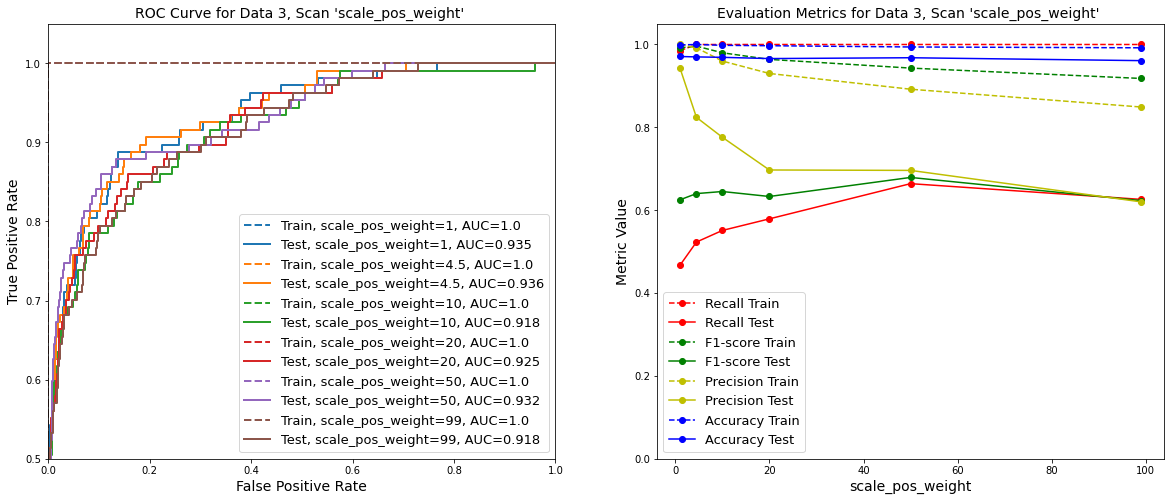

In [41]:
#Scan scale_pos_weight, 
# max_depth=4

xgbParams = {
    'eval_metric': 'logloss', 
    'random_state': 42,
    'max_depth': 4
}

scanParam = 'scale_pos_weight'

scanList = [1, 4.5, 10, 20, 50, 99]
#scanList = [1, 4.5]

result_spw_depth4= scan_xgb_ROC_metrics(3, X_train, y_train, X_test, y_test, xgbParams, scanParam, scanList, 0, 1, 0)

In [53]:
# max_depth=4, scale_pos_weight=50

xgbParams = {
    'eval_metric': 'logloss', 
    'random_state': 42,
    'max_depth': 4,
    'scale_pos_weight': 50,
}

model_spw50_depth4 = xgb_model_report(3, X_train, y_train, X_test, y_test, xgbParams, 'XGB Model', 0, 0, 1)

Data 3 Classification Report:

Training Data:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00      8014
           1       0.89      1.00      0.94       388

    accuracy                           0.99      8402
   macro avg       0.95      1.00      0.97      8402
weighted avg       1.00      0.99      0.99      8402

Testing Data:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      1994
           1       0.70      0.66      0.68       107

    accuracy                           0.97      2101
   macro avg       0.84      0.82      0.83      2101
weighted avg       0.97      0.97      0.97      2101



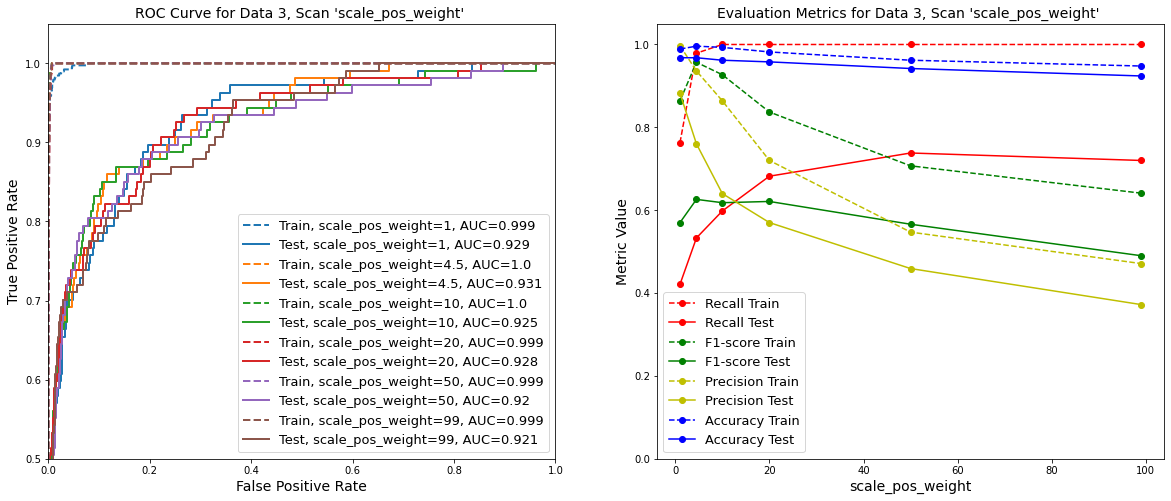

In [42]:
#Scan scale_pos_weight, 
# max_depth=3

xgbParams = {
    'eval_metric': 'logloss', 
    'random_state': 42,
    'max_depth': 3
}

scanParam = 'scale_pos_weight'

scanList = [1, 4.5, 10, 20, 50, 99]
#scanList = [1, 4.5]

result_spw_depth3= scan_xgb_ROC_metrics(3, X_train, y_train, X_test, y_test, xgbParams, scanParam, scanList, 0, 1, 0)

In [55]:
# max_depth=3, scale_pos_weight=20

xgbParams = {
    'eval_metric': 'logloss', 
    'random_state': 42,
    'max_depth': 3,
    'scale_pos_weight': 20,
}

model_spw20_depth3 = xgb_model_report(3, X_train, y_train, X_test, y_test, xgbParams, 'XGB Model', 0, 0, 1)

Data 3 Classification Report:

Training Data:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99      8014
           1       0.72      1.00      0.84       388

    accuracy                           0.98      8402
   macro avg       0.86      0.99      0.91      8402
weighted avg       0.99      0.98      0.98      8402

Testing Data:
               precision    recall  f1-score   support

           0       0.98      0.97      0.98      1994
           1       0.57      0.68      0.62       107

    accuracy                           0.96      2101
   macro avg       0.78      0.83      0.80      2101
weighted avg       0.96      0.96      0.96      2101



,precision,recall,f1,accuracy,auc
Params,,,,,
"max_depth=6, scale_pos_weight=10 Train",1.000,1.000,1.000,1.000,1.000
Test,0.882,0.561,0.686,0.974,0.920
"max_depth=5, scale_pos_weight=50 Train",0.990,1.000,0.995,1.000,1.000
Test,0.759,0.561,0.645,0.969,0.921
"max_depth=4, scale_pos_weight=50 Train",0.892,1.000,0.943,0.994,1.000
Test,0.696,0.664,0.679,0.968,0.932
"max_depth=3, scale_pos_weight=20 Train",0.720,1.000,0.837,0.982,0.999
Test,0.570,0.682,0.621,0.958,0.928


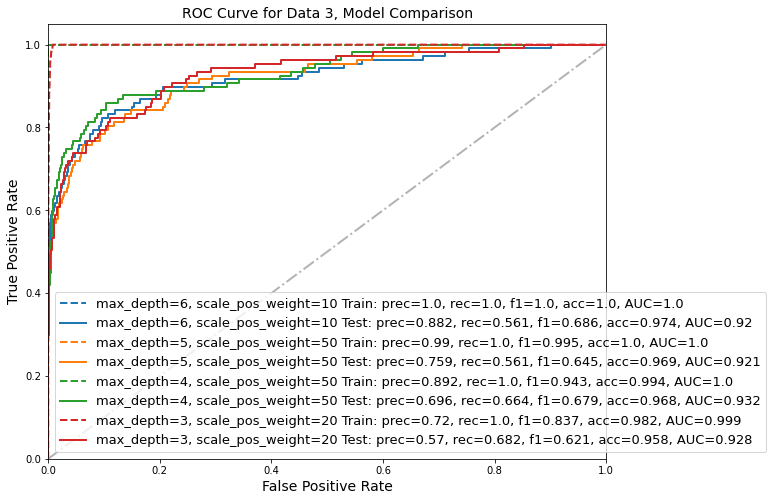

In [56]:
#Compare models with optimum scale_pos_weight 

model_list = [model_spw10_depth6, model_spw50_depth5, model_spw50_depth4, model_spw20_depth3]

model_names_list = ['max_depth=6, scale_pos_weight=10',
                    'max_depth=5, scale_pos_weight=50',
                    'max_depth=4, scale_pos_weight=50',
                    'max_depth=3, scale_pos_weight=20',
                    ]

compare_models(3, X_train, y_train, X_test, y_test, model_list, model_names_list, 'imbalance_spw_optimum', 1, 1)


**Comments**
* The model performance improves compared to the baseline model (Model 1) where default scale_pos_weight=1.
* The optimum value may be different when other parameters change, for instance max_depth.
* The optimum scale_pos_weight:
    * scale_pos_weight=10 at max_depth=6
    * scale_pos_weight=50 at max_depth=5
    * scale_pos_weight=50 at max_depth=4
    * scale_pos_weight=20 at max_depth=3
* Overfitting observed.
* The optimum value may be different when another data set is used. It may require additional parameter tuning.

### class_weight + scale_pos_weight


Sample weights are used!
--------



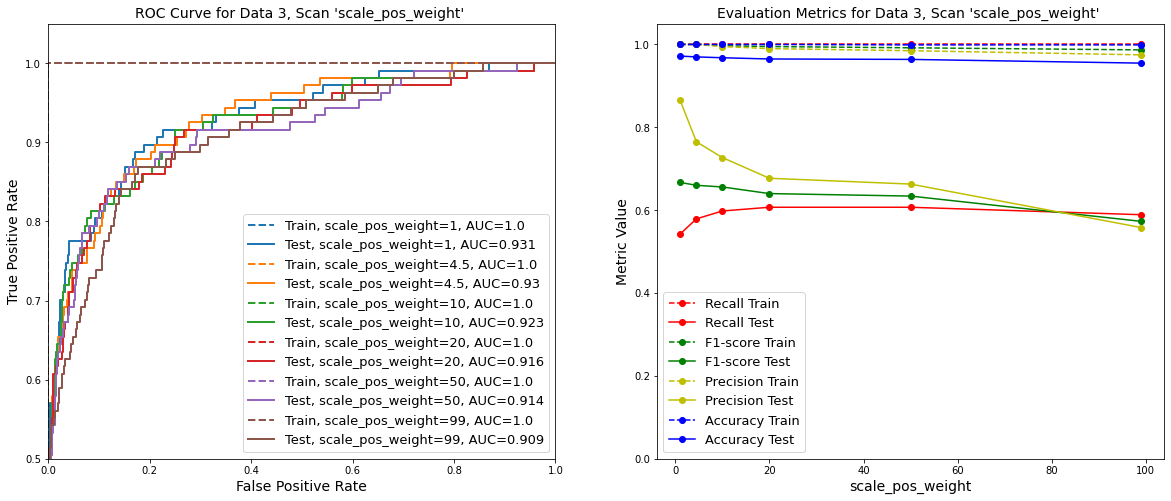

In [57]:
#Scan scale_pos_weight
# sample_weight applied
#max_depth=6

xgbParams = {
    'eval_metric': 'logloss', 
    'random_state': 42,
}

scanParam = 'scale_pos_weight'

scanList = [1, 4.5, 10, 20, 50, 99]
#scanList = [1, 4.5]

result_spw_sw_depth6 = scan_xgb_ROC_metrics(3, X_train, y_train, X_test, y_test, xgbParams, scanParam, scanList, 1, 1, 0)


Sample weights are used!
--------



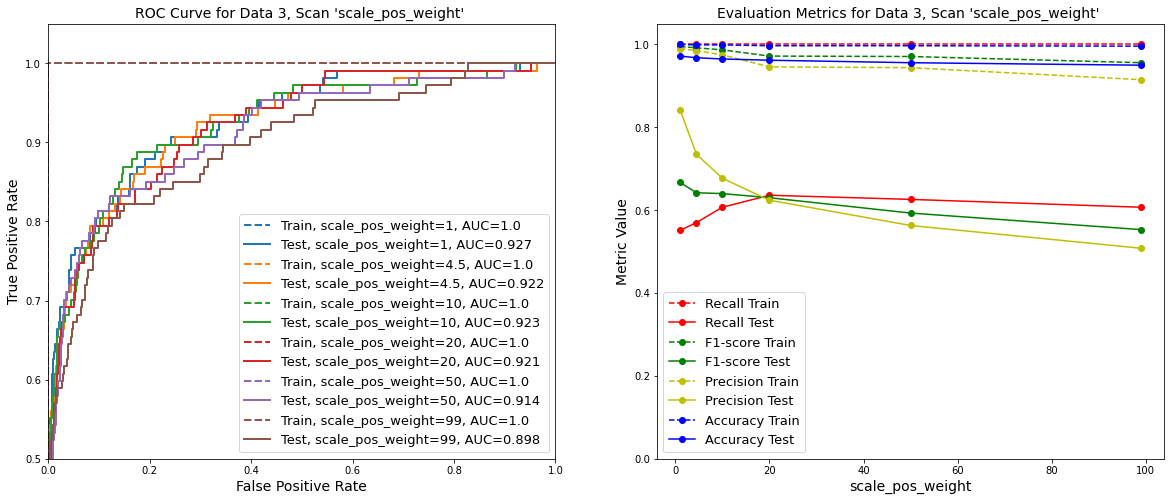

In [58]:
#Scan scale_pos_weight
# sample_weight applied
# max_depth=5

xgbParams = {
    'eval_metric': 'logloss', 
    'random_state': 42,
    'max_depth': 5,
}

scanParam = 'scale_pos_weight'

scanList = [1, 4.5, 10, 20, 50, 99]
#scanList = [1, 4.5]

result_spw_sw_depth5 = scan_xgb_ROC_metrics(3, X_train, y_train, X_test, y_test, xgbParams, scanParam, scanList, 1, 1, 0)



Sample weights are used!
--------



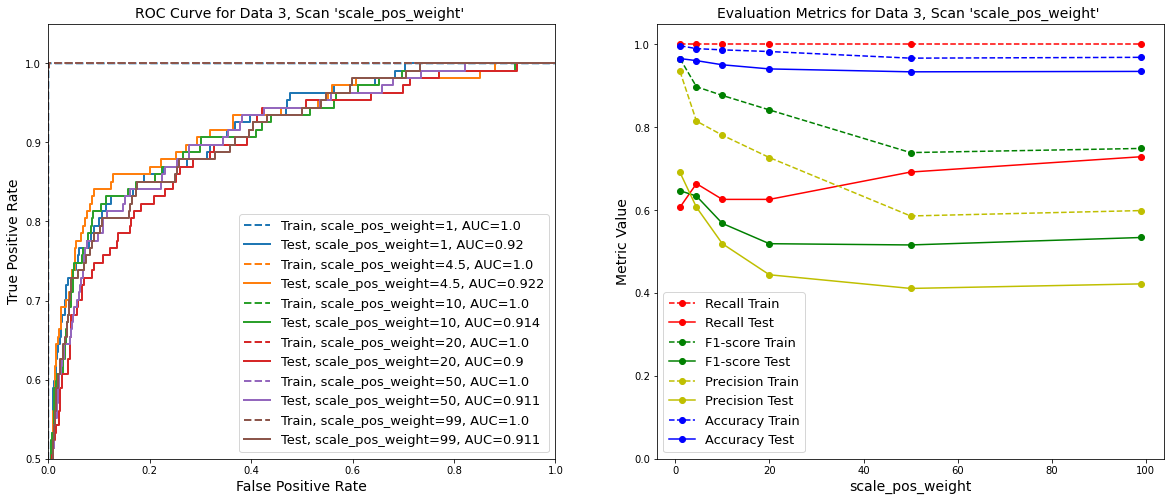

In [60]:
#Scan scale_pos_weight
# sample_weight applied
# max_depth=4

xgbParams = {
    'eval_metric': 'logloss', 
    'random_state': 42,
    'max_depth': 4,
}

scanParam = 'scale_pos_weight'

scanList = [1, 4.5, 10, 20, 50, 99]
#scanList = [1, 4.5]

result_spw_sw_depth4 = scan_xgb_ROC_metrics(3, X_train, y_train, X_test, y_test, xgbParams, scanParam, scanList, 1, 1, 0)


Sample weights are used!
--------



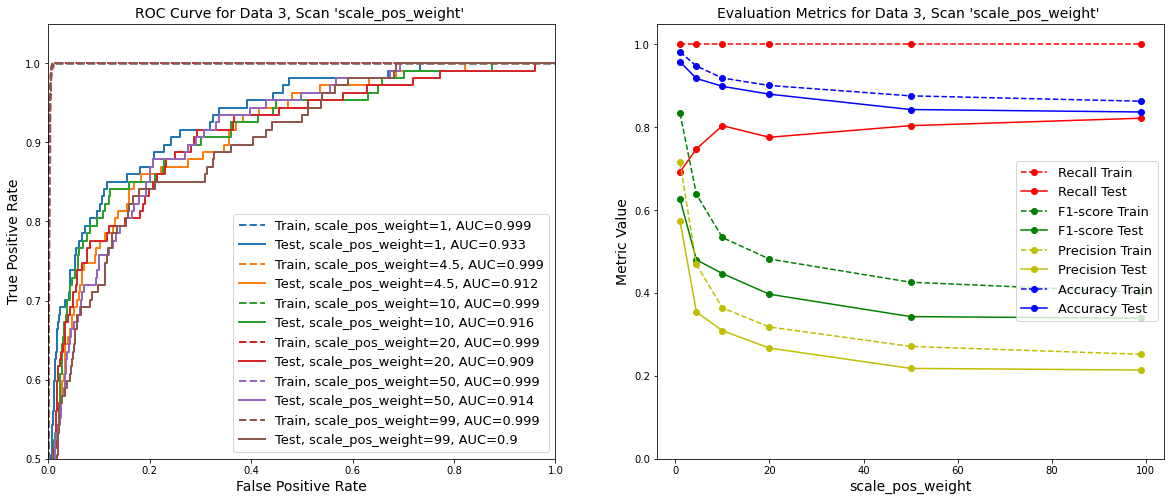

In [59]:
#Scan scale_pos_weight
# sample_weight applied
# max_depth=3

xgbParams = {
    'eval_metric': 'logloss', 
    'random_state': 42,
    'max_depth': 3,
}

scanParam = 'scale_pos_weight'

scanList = [1, 4.5, 10, 20, 50, 99]
#scanList = [1, 4.5]

result_spw_sw_depth3 = scan_xgb_ROC_metrics(3, X_train, y_train, X_test, y_test, xgbParams, scanParam, scanList, 1, 1, 0)


Sample weights are used!
--------

Sample weights are used!
--------

Sample weights are used!
--------



,precision,recall,f1,accuracy,auc
Params,,,,,
sample_weight Train,1.000,1.000,1.000,1.000,1.000
Test,0.866,0.542,0.667,0.972,0.931
scale_pos_weight=10 Train,1.000,1.000,1.000,1.000,1.000
Test,0.882,0.561,0.686,0.974,0.920
sample_weight + scale_pos_weight=20 Train,0.990,1.000,0.995,1.000,1.000
Test,0.677,0.607,0.640,0.965,0.916
sample_weight + scale_pos_weight=50 Train,0.985,1.000,0.992,0.999,1.000
Test,0.663,0.607,0.634,0.964,0.914


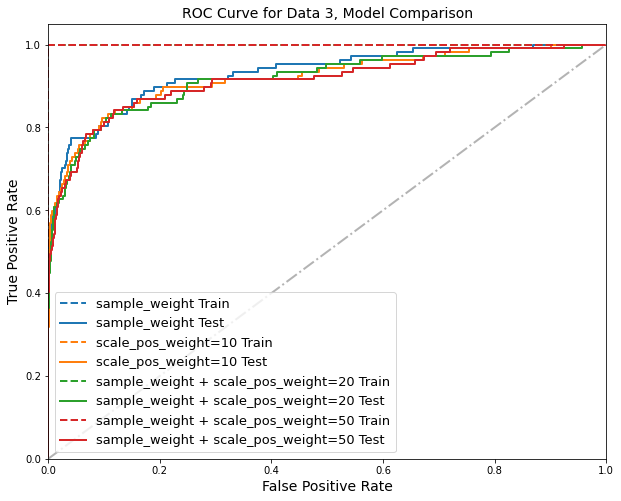

In [14]:
#Compare balance methods at max_depth=6

xgbParams1 = {
    'eval_metric': 'logloss', 
    'random_state': 42,
    'max_depth': 6,
}

mod1 = xgb_model_report(3, X_train, y_train, X_test, y_test, xgbParams1, 'XGB Model', 1, 0, 0)

xgbParams2 = {
    'eval_metric': 'logloss', 
    'random_state': 42,
    'max_depth': 6,
    'scale_pos_weight': 10,
}

mod2 = xgb_model_report(3, X_train, y_train, X_test, y_test, xgbParams2, 'XGB Model', 0, 0, 0)

xgbParams3 = {
    'eval_metric': 'logloss', 
    'random_state': 42,
    'max_depth': 6,
    'scale_pos_weight': 20,
}

mod3 = xgb_model_report(3, X_train, y_train, X_test, y_test, xgbParams3, 'XGB Model', 1, 0, 0)

xgbParams4 = {
    'eval_metric': 'logloss', 
    'random_state': 42,
    'max_depth': 6,
    'scale_pos_weight': 50,
}

mod4 = xgb_model_report(3, X_train, y_train, X_test, y_test, xgbParams4, 'XGB Model', 1, 0, 0)

model_list = [mod1, mod2, mod3, mod4]

model_names_list = ['sample_weight', 'scale_pos_weight=10', 'sample_weight + scale_pos_weight=20', 'sample_weight + scale_pos_weight=50']

compare_models(3, X_train, y_train, X_test, y_test, model_list, model_names_list, 'imbalance_depth6', 1, 1)


Sample weights are used!
--------

Sample weights are used!
--------



,precision,recall,f1,accuracy,auc
Params,,,,,
sample_weight Train,0.990,1.000,0.995,1.000,1.000
Test,0.843,0.551,0.667,0.972,0.927
scale_pos_weight=50 Train,0.990,1.000,0.995,1.000,1.000
Test,0.759,0.561,0.645,0.969,0.921
sample_weight + scale_pos_weight=20 Train,0.946,1.000,0.972,0.997,1.000
Test,0.624,0.636,0.630,0.962,0.921


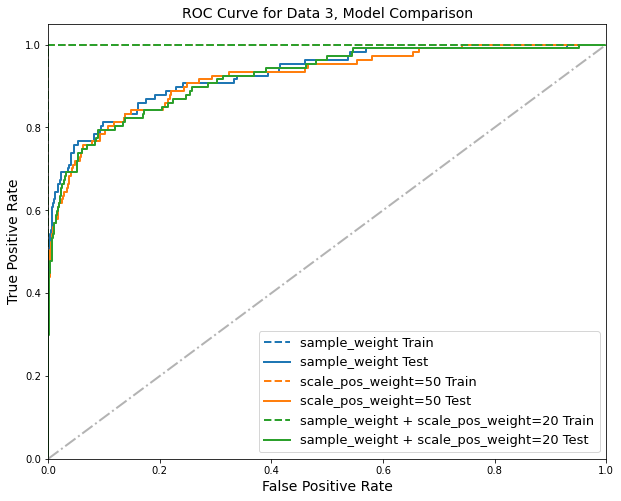

In [8]:
#Compare balance methods at max_depth=5

xgbParams1 = {
    'eval_metric': 'logloss', 
    'random_state': 42,
    'max_depth': 5,
}

mod1 = xgb_model_report(3, X_train, y_train, X_test, y_test, xgbParams1, 'XGB Model', 1, 0, 0)

xgbParams2 = {
    'eval_metric': 'logloss', 
    'random_state': 42,
    'max_depth': 5,
    'scale_pos_weight': 50,
}

mod2 = xgb_model_report(3, X_train, y_train, X_test, y_test, xgbParams2, 'XGB Model', 0, 0, 0)

xgbParams3 = {
    'eval_metric': 'logloss', 
    'random_state': 42,
    'max_depth': 5,
    'scale_pos_weight': 20,
}

mod3 = xgb_model_report(3, X_train, y_train, X_test, y_test, xgbParams3, 'XGB Model', 1, 0, 0)

model_list = [mod1, mod2, mod3]

model_names_list = ['sample_weight', 'scale_pos_weight=50', 'sample_weight + scale_pos_weight=20']

compare_models(3, X_train, y_train, X_test, y_test, model_list, model_names_list, 'imbalance_depth5', 1, 1)


Sample weights are used!
--------

Sample weights are used!
--------

Sample weights are used!
--------



,precision,recall,f1,accuracy,auc
Params,,,,,
sample_weight Train,0.935,1.000,0.966,0.997,1.000
Test,0.691,0.607,0.647,0.966,0.920
scale_pos_weight=50 Train,0.892,1.000,0.943,0.994,1.000
Test,0.696,0.664,0.679,0.968,0.932
sample_weight + scale_pos_weight=4.5 Train,0.815,1.000,0.898,0.990,1.000
Test,0.607,0.664,0.634,0.961,0.922
sample_weight + scale_pos_weight=50 Train,0.586,1.000,0.739,0.967,1.000
Test,0.411,0.692,0.516,0.934,0.911


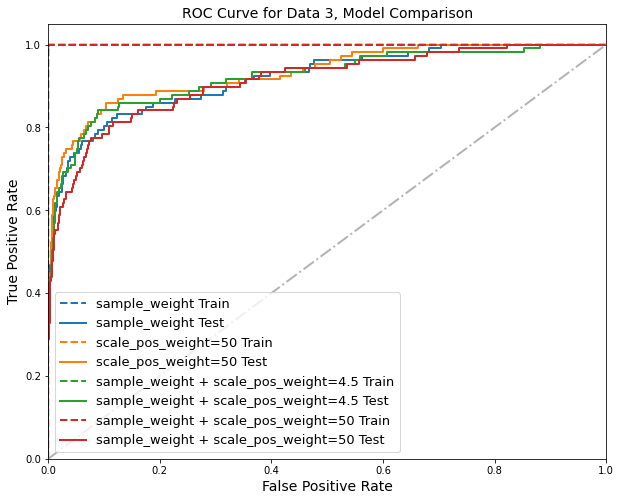

In [13]:
#Compare balance methods at max_depth=4

xgbParams1 = {
    'eval_metric': 'logloss', 
    'random_state': 42,
    'max_depth': 4,
}

mod1 = xgb_model_report(3, X_train, y_train, X_test, y_test, xgbParams1, 'XGB Model', 1, 0, 0)

xgbParams2 = {
    'eval_metric': 'logloss', 
    'random_state': 42,
    'max_depth': 4,
    'scale_pos_weight': 50,
}

mod2 = xgb_model_report(3, X_train, y_train, X_test, y_test, xgbParams2, 'XGB Model', 0, 0, 0)

xgbParams3 = {
    'eval_metric': 'logloss', 
    'random_state': 42,
    'max_depth': 4,
    'scale_pos_weight': 4.5,
}

mod3 = xgb_model_report(3, X_train, y_train, X_test, y_test, xgbParams3, 'XGB Model', 1, 0, 0)

xgbParams4 = {
    'eval_metric': 'logloss', 
    'random_state': 42,
    'max_depth': 4,
    'scale_pos_weight': 50,
}

mod4 = xgb_model_report(3, X_train, y_train, X_test, y_test, xgbParams4, 'XGB Model', 1, 0, 0)

model_list = [mod1, mod2, mod3, mod4]

model_names_list = ['sample_weight', 'scale_pos_weight=50', 'sample_weight + scale_pos_weight=4.5', 'sample_weight + scale_pos_weight=50']

compare_models(3, X_train, y_train, X_test, y_test, model_list, model_names_list, 'imbalance_depth4', 1, 1)


Sample weights are used!
--------

Sample weights are used!
--------



,precision,recall,f1,accuracy,auc
Params,,,,,
sample_weight Train,0.716,1.000,0.834,0.982,0.999
Test,0.574,0.692,0.627,0.958,0.933
scale_pos_weight=50 Train,0.720,1.000,0.837,0.982,0.999
Test,0.570,0.682,0.621,0.958,0.928
sample_weight + scale_pos_weight=1 Train,0.716,1.000,0.834,0.982,0.999
Test,0.574,0.692,0.627,0.958,0.933


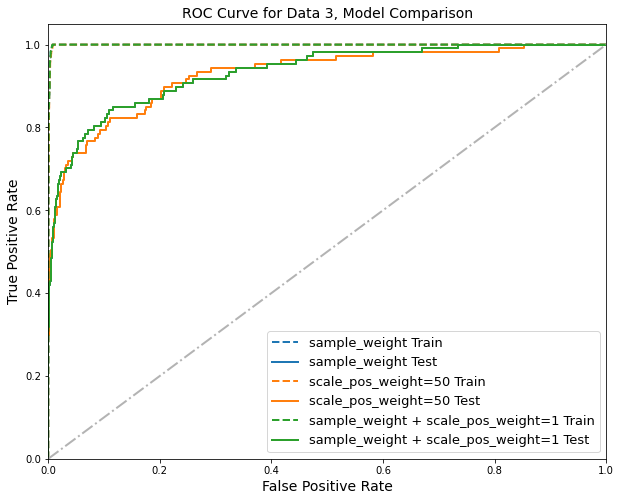

In [12]:
#Compare balance methods at max_depth=3

xgbParams1 = {
    'eval_metric': 'logloss', 
    'random_state': 42,
    'max_depth': 3,
}

mod1 = xgb_model_report(3, X_train, y_train, X_test, y_test, xgbParams1, 'XGB Model', 1, 0, 0)

xgbParams2 = {
    'eval_metric': 'logloss', 
    'random_state': 42,
    'max_depth': 3,
    'scale_pos_weight': 20,
}

mod2 = xgb_model_report(3, X_train, y_train, X_test, y_test, xgbParams2, 'XGB Model', 0, 0, 0)

xgbParams3 = {
    'eval_metric': 'logloss', 
    'random_state': 42,
    'max_depth': 3,
    'scale_pos_weight': 1,
}

mod3 = xgb_model_report(3, X_train, y_train, X_test, y_test, xgbParams3, 'XGB Model', 1, 0, 0)

model_list = [mod1, mod2, mod3]

model_names_list = ['sample_weight', 'scale_pos_weight=50', 'sample_weight + scale_pos_weight=1']

compare_models(3, X_train, y_train, X_test, y_test, model_list, model_names_list, 'imbalance_depth4', 1, 1)


**Comments**
* The optimum imbalance depends on the max_depth.
    * max_depth=6: sample_weight + scale_pos_weight=20
    * max_depth=5: sample_weight + scale_pos_weight=20
    * max_depth=4: sample_weight + scale_pos_weight=4.5
    * max_depth=3: sample_weight + scale_pos_weight=1
* The optimum value may be different when another data set is used.